## plot codon ribo density 

### req libs

In [1]:
options(warn=-1)
source("https://bioconductor.org/biocLite.R")
library(stringr)  # string manipulation
library(BSgenome)  # genome manipulation
library(tidyverse)  # tables, plotting, read-write
library(magrittr)  # nice piping operators
library(svglite)

# color palette for codons
cbPalette <- c("#CC79A7", "#E69F00", "#D55E00",
               "#0072B2", "#56B4E9", "#009E73")

Bioconductor version 3.5 (BiocInstaller 1.26.0), ?biocLite for help
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min

Loading required p

### get filenames and sample pairs

In [2]:
# get all codon ribo density files
codonfiles <- list.files('../processeddata/',
                         pattern = 'codon.ribo.density_overhang150.tsv',
                         recursive = T, full.names = T)

# parse sample names
samples  <- str_match(codonfiles, 'processeddata//(.*)/')[,2]
# get sample pairs for ribosome density diff calc
# these pairs are written in the '.org' file and exported to '.tsv'
samplepairs = read_tsv('../tables/samplepairs_codon_density.tsv')
samplepairs

Parsed with column specification:
cols(
  top = col_character(),
  bottom = col_character(),
  plotaa = col_character(),
  plotnumber = col_integer(),
  perturblevel = col_integer()
)


top,bottom,plotaa,plotnumber,perturblevel
hct116_arg_3h,hct116_rich_3h,R,1,1
hct116_leu_3h,hct116_rich_3h,L,1,1
hela_arg_mono_3h,hela_rich_mono_3h,R,1,1
hela_leu_mono_3h,hela_rich_mono_3h,L,1,1
293t_hrgfp_arg_3h,293t_hrgfp_rich_3h,R,1,1
293t_hrgfp_leu_3h,293t_hrgfp_rich_3h,L,1,1
293t_arg_6h,293t_rich_6h,R,2,1
293t_leu_6h,293t_rich_6h,L,2,1
hrgfp_arg_6h,hrgfp_rich_6h,R,2,2
hrgfp_leu_6h,hrgfp_rich_6h,L,2,2


### pair codon - aa

In [3]:
# get codon-aa pairings
codon.table  <- GENETIC_CODE %>% 
  as_tibble() %>%
  rownames_to_column(var='codon') %>%
  dplyr::rename(., aa=value) %T>%
  print

# A tibble: 64 x 2
   codon    aa
   <chr> <chr>
 1   TTT     F
 2   TTC     F
 3   TTA     L
 4   TTG     L
 5   TCT     S
 6   TCC     S
 7   TCA     S
 8   TCG     S
 9   TAT     Y
10   TAC     Y
# ... with 54 more rows


### import data into dataframe

In [4]:
data <- codonfiles %>% 
  # apply to each codon file
  lapply(. %>%
         # read file with first col as string
         read_tsv(col_types = c(col_character())) %>% 
         # gather all positions into single column
         gather(position, density, -codon) %>% 
         # convert position to integer
         mutate(position = as.integer(position))
        ) %>% 
  # give each sample the correct name
  set_names(samples) %>% 
  # join all sample data into one dataframe
  bind_rows(.id = 'sample') %>% 
  # add aa for each codon
  left_join(codon.table, by = 'codon') %T>%
  print

# A tibble: 494,100 x 5
        sample codon position density    aa
         <chr> <chr>    <int>   <dbl> <chr>
 1 293t_arg_6h   TTT     -150  1.0084     F
 2 293t_arg_6h   TTC     -150  1.0499     F
 3 293t_arg_6h   TTA     -150  1.0636     L
 4 293t_arg_6h   TTG     -150  1.0335     L
 5 293t_arg_6h   TCT     -150  1.0198     S
 6 293t_arg_6h   TCC     -150  1.0157     S
 7 293t_arg_6h   TCA     -150  0.9989     S
 8 293t_arg_6h   TCG     -150  0.9464     S
 9 293t_arg_6h   TAT     -150  1.0801     Y
10 293t_arg_6h   TAC     -150  1.0498     Y
# ... with 494,090 more rows


### calculate density differences ###

In [5]:
pairsamples <- function(top, bottom, data) {
  # get all points for sample1
  df1 <- data %>% filter(sample == top)
  # get all points for sample2
  df2 <- data %>% filter(sample == bottom)
  df <- df1 %>%
    # join both data frames
    inner_join(df2, by=c("aa", "codon", "position")) %>% 
    # calculate density difference
    mutate(density.diff=density.x-density.y)
  df
}

density.diff  <- map2(samplepairs[['top']], 
                      samplepairs[['bottom']], 
                      pairsamples, data) %>% 
  bind_rows %>% 
  # join with samplepairs to get plot number and plot aa
  left_join(samplepairs, by = c("sample.x" = "top", "sample.y" = "bottom")) %>%
  # extract annotations for easy plotting
  mutate(cellline=str_extract(sample.x, '293t|hela|hct116'),
         starv=str_extract(sample.x, 'arg|leu'),
         modification=str_extract(sample.x, 'gcn2ko|hrgfp|ragbq99l'),
         drug=str_extract(sample.x, 'torin')) %T>% 
  print

# A tibble: 292,800 x 15
        sample.x codon position density.x    aa       sample.y density.y
           <chr> <chr>    <int>     <dbl> <chr>          <chr>     <dbl>
 1 hct116_arg_3h   TTT     -150    1.0032     F hct116_rich_3h    1.0608
 2 hct116_arg_3h   TTC     -150    1.0220     F hct116_rich_3h    1.0451
 3 hct116_arg_3h   TTA     -150    1.0791     L hct116_rich_3h    1.0832
 4 hct116_arg_3h   TTG     -150    1.0252     L hct116_rich_3h    1.0404
 5 hct116_arg_3h   TCT     -150    1.0306     S hct116_rich_3h    1.0137
 6 hct116_arg_3h   TCC     -150    1.0787     S hct116_rich_3h    0.9995
 7 hct116_arg_3h   TCA     -150    0.9455     S hct116_rich_3h    0.9651
 8 hct116_arg_3h   TCG     -150    1.1799     S hct116_rich_3h    1.1562
 9 hct116_arg_3h   TAT     -150    1.0647     Y hct116_rich_3h    1.0444
10 hct116_arg_3h   TAC     -150    1.0921     Y hct116_rich_3h    1.0932
# ... with 292,790 more rows, and 8 more variables: density.diff <dbl>,
#   plotaa <chr>, plotnumbe

### calculate summed increase in read density in the 200 nt window around codons ###

In [6]:
density.diff.sum <- density.diff %>% 
  group_by(codon, aa, sample.x, sample.y) %>% 
  select(density.diff) %>% 
  summarise(density.sum = sum(density.diff)) %>%  
  # join with samplepairs to get plot number and plot aa
  left_join(samplepairs, by = c("sample.x" = "top", "sample.y" = "bottom")) %>%
  # extract annotations for easy plotting
  mutate(cellline=str_extract(sample.x, '293t|hela|hct116'),
         starv=str_extract(sample.x, 'arg|leu'),
         modification=str_extract(sample.x, 'gcn2ko|hrgfp|ragbq99l'),
         drug=str_extract(sample.x, 'torin'),
         samplepair = paste0(sample.x, ' – ', sample.y)) %>% 
  ungroup %>%
  arrange(samplepair, codon) %T>%
  write_tsv('../tables/codon.density.diff.sum.tsv') %>% 
  print

Adding missing grouping variables: `codon`, `aa`, `sample.x`, `sample.y`


# A tibble: 976 x 13
   codon    aa    sample.x     sample.y density.sum plotaa plotnumber
   <chr> <chr>       <chr>        <chr>       <dbl>  <chr>      <int>
 1   AAA     K 293t_arg_6h 293t_rich_6h     -3.1123      R          2
 2   AAC     N 293t_arg_6h 293t_rich_6h     -1.8854      R          2
 3   AAG     K 293t_arg_6h 293t_rich_6h     -4.8303      R          2
 4   AAT     N 293t_arg_6h 293t_rich_6h     -4.4490      R          2
 5   ACA     T 293t_arg_6h 293t_rich_6h     -3.6922      R          2
 6   ACC     T 293t_arg_6h 293t_rich_6h     -3.1449      R          2
 7   ACG     T 293t_arg_6h 293t_rich_6h     -3.3282      R          2
 8   ACT     T 293t_arg_6h 293t_rich_6h     -3.1201      R          2
 9   AGA     R 293t_arg_6h 293t_rich_6h     17.3741      R          2
10   AGC     S 293t_arg_6h 293t_rich_6h      1.1971      R          2
# ... with 966 more rows, and 6 more variables: perturblevel <int>,
#   cellline <chr>, starv <chr>, modification <chr>, drug <chr>,
#   sa

### plot codon density difference & summed density across cell types

In [8]:
density.diff
#write.csv(file='../tables/density.diff.20170815.csv', x=density.diff)

sample.x,codon,position,density.x,aa,sample.y,density.y,density.diff,plotaa,plotnumber,perturblevel,cellline,starv,modification,drug
hct116_arg_3h,TTT,-150,1.0032,F,hct116_rich_3h,1.0608,-0.0576,R,1,1,hct116,arg,NA,NA
hct116_arg_3h,TTC,-150,1.0220,F,hct116_rich_3h,1.0451,-0.0231,R,1,1,hct116,arg,NA,NA
hct116_arg_3h,TTA,-150,1.0791,L,hct116_rich_3h,1.0832,-0.0041,R,1,1,hct116,arg,NA,NA
hct116_arg_3h,TTG,-150,1.0252,L,hct116_rich_3h,1.0404,-0.0152,R,1,1,hct116,arg,NA,NA
hct116_arg_3h,TCT,-150,1.0306,S,hct116_rich_3h,1.0137,0.0169,R,1,1,hct116,arg,NA,NA
hct116_arg_3h,TCC,-150,1.0787,S,hct116_rich_3h,0.9995,0.0792,R,1,1,hct116,arg,NA,NA
hct116_arg_3h,TCA,-150,0.9455,S,hct116_rich_3h,0.9651,-0.0196,R,1,1,hct116,arg,NA,NA
hct116_arg_3h,TCG,-150,1.1799,S,hct116_rich_3h,1.1562,0.0237,R,1,1,hct116,arg,NA,NA
hct116_arg_3h,TAT,-150,1.0647,Y,hct116_rich_3h,1.0444,0.0203,R,1,1,hct116,arg,NA,NA
hct116_arg_3h,TAC,-150,1.0921,Y,hct116_rich_3h,1.0932,-0.0011,R,1,1,hct116,arg,NA,NA


In [20]:
density.diff.sum
#write.csv(file='../tables/density.diff.sum.20170815.csv', x=density.diff.sum)

codon,aa,sample.x,sample.y,density.sum,plotaa,plotnumber,cellline,starv,modification,drug,samplepair
AAA,K,293t_arg_6h,293t_rich_6h,-3.1123,R,2,293t,arg,NA,NA,293t_arg_6h – 293t_rich_6h
AAC,N,293t_arg_6h,293t_rich_6h,-1.8854,R,2,293t,arg,NA,NA,293t_arg_6h – 293t_rich_6h
AAG,K,293t_arg_6h,293t_rich_6h,-4.8303,R,2,293t,arg,NA,NA,293t_arg_6h – 293t_rich_6h
AAT,N,293t_arg_6h,293t_rich_6h,-4.4490,R,2,293t,arg,NA,NA,293t_arg_6h – 293t_rich_6h
ACA,T,293t_arg_6h,293t_rich_6h,-3.6922,R,2,293t,arg,NA,NA,293t_arg_6h – 293t_rich_6h
ACC,T,293t_arg_6h,293t_rich_6h,-3.1449,R,2,293t,arg,NA,NA,293t_arg_6h – 293t_rich_6h
ACG,T,293t_arg_6h,293t_rich_6h,-3.3282,R,2,293t,arg,NA,NA,293t_arg_6h – 293t_rich_6h
ACT,T,293t_arg_6h,293t_rich_6h,-3.1201,R,2,293t,arg,NA,NA,293t_arg_6h – 293t_rich_6h
AGA,R,293t_arg_6h,293t_rich_6h,17.3741,R,2,293t,arg,NA,NA,293t_arg_6h – 293t_rich_6h
AGC,S,293t_arg_6h,293t_rich_6h,1.1971,R,2,293t,arg,NA,NA,293t_arg_6h – 293t_rich_6h


### Figure 1

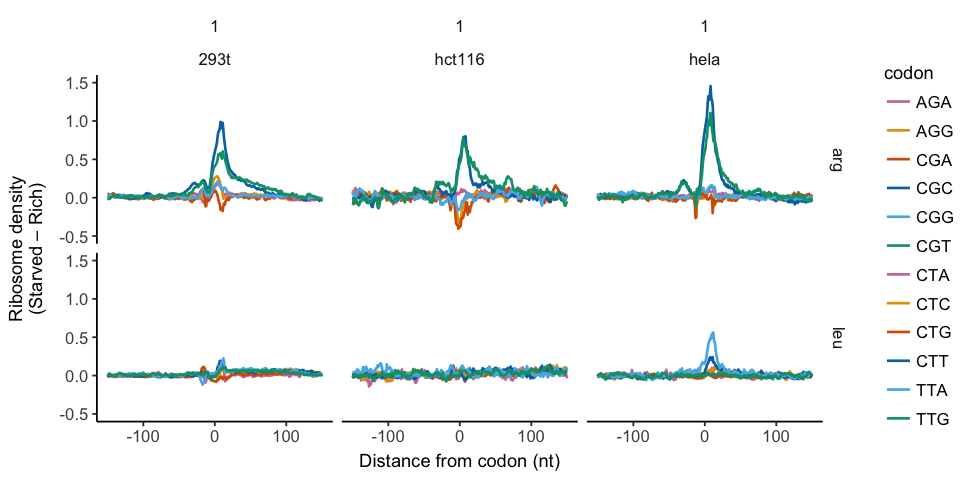

In [11]:
library(svglite)
options(repr.plot.width = 8, repr.plot.height = 4)
p <- density.diff %>% 
  filter(plotnumber == 1 & plotaa == aa)  %>% 
  ggplot(aes(x = position, y = density.diff, color = codon))

p + 
  geom_line(size=.75) +
  facet_grid(starv ~ perturblevel + cellline) +
  # set colors manually
  scale_colour_manual(values=rep(cbPalette, 2)) +
  # set scales manually
  scale_x_continuous(limits=c(-150, 150)) +
  scale_y_continuous(limits=c(-0.5, 1.5)) +
  labs(x = 'Distance from codon (nt)',
       y = 'Ribosome density\n(Starved \u2013 Rich)') +
  theme_classic(base_family='Arial') +
  theme(strip.background=element_blank(), axis.text=element_text(size=10), legend.text=element_text(size=10), strip.text=element_text(size=10))


ggsave('../figures/20170912_codondensitydifference_celltypes_lwfontadj.svg',
       width = 8, height = 4,units = 'in')

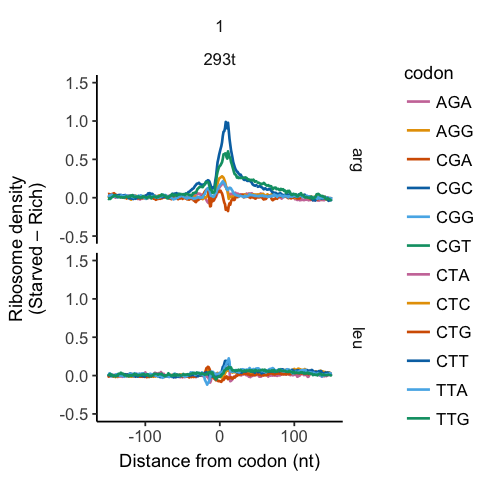

In [10]:
library(svglite)
options(repr.plot.width = 4, repr.plot.height = 4)
p <- density.diff %>% 
  filter(plotnumber == 1 & plotaa == aa & cellline == '293t')  %>% 
  ggplot(aes(x = position, y = density.diff, color = codon))

p + 
  geom_line(size=.75) +
  facet_grid(starv ~ perturblevel + cellline) +
  # set colors manually
  scale_colour_manual(values=rep(cbPalette, 2)) +
  # set scales manually
  scale_x_continuous(limits=c(-150, 150)) +
  scale_y_continuous(limits=c(-0.5, 1.5)) +
  labs(x = 'Distance from codon (nt)',
       y = 'Ribosome density\n(Starved \u2013 Rich)') +
  theme_classic(base_family='Arial') +
  theme(strip.background=element_blank(), axis.text=element_text(size=10), legend.text=element_text(size=10), strip.text=element_text(size=10))
#everything is off by a scaling factor of 0.8? so adjusted size 8 text to 8/.8 = 10?  this gives all text size 8 except axis titles size 8.8 - adjust theme_classic()base_size to 10 to fix all to 8. 
ggsave('../figures/20170912_codondensitydifference_hek293t_lwfontadj.svg',
       width = 4, height = 4,units = 'in')

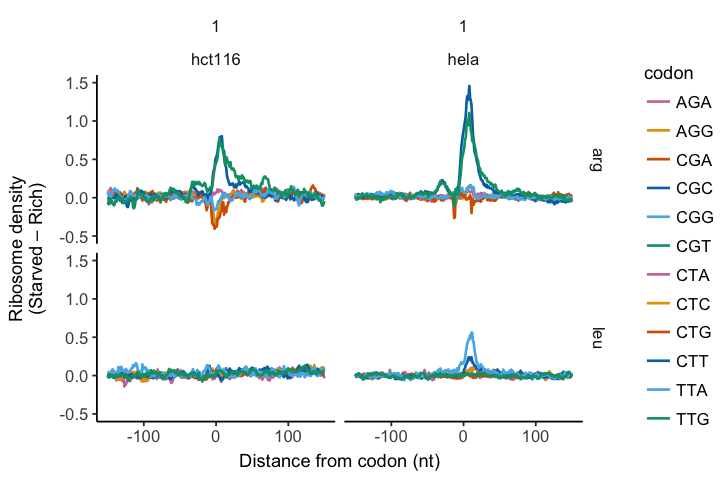

In [9]:
library(svglite)
options(repr.plot.width = 6, repr.plot.height = 4)
p <- density.diff %>% 
  filter(plotnumber == 1 & plotaa == aa & cellline != '293t')  %>% 
  ggplot(aes(x = position, y = density.diff, color = codon))

p + 
  geom_line(size=.75) +
  facet_grid(starv ~ perturblevel + cellline) +
  # set colors manually
  scale_colour_manual(values=rep(cbPalette, 2)) +
  # set scales manually
  scale_x_continuous(limits=c(-150, 150)) +
  scale_y_continuous(limits=c(-0.5, 1.5)) +
  labs(x = 'Distance from codon (nt)',
       y = 'Ribosome density\n(Starved \u2013 Rich)') +
  theme_classic(base_family='Arial') +
  theme(strip.background=element_blank(), axis.text=element_text(size=10), legend.text=element_text(size=10), strip.text=element_text(size=10))
#everything is off by a scaling factor of 0.8? so adjusted size 8 text to 8/.8 = 10?  this gives all text size 8 except axis titles size 8.8 - adjust theme_classic()base_size to 10 to fix all to 8. 
ggsave('../figures/20170912_codondensitydifference_hct116hela_lwfontadj.svg',
       width = 6, height = 4,units = 'in')

#HOW TO CHANGE ORDER OF PLOTS (arg above leu?)

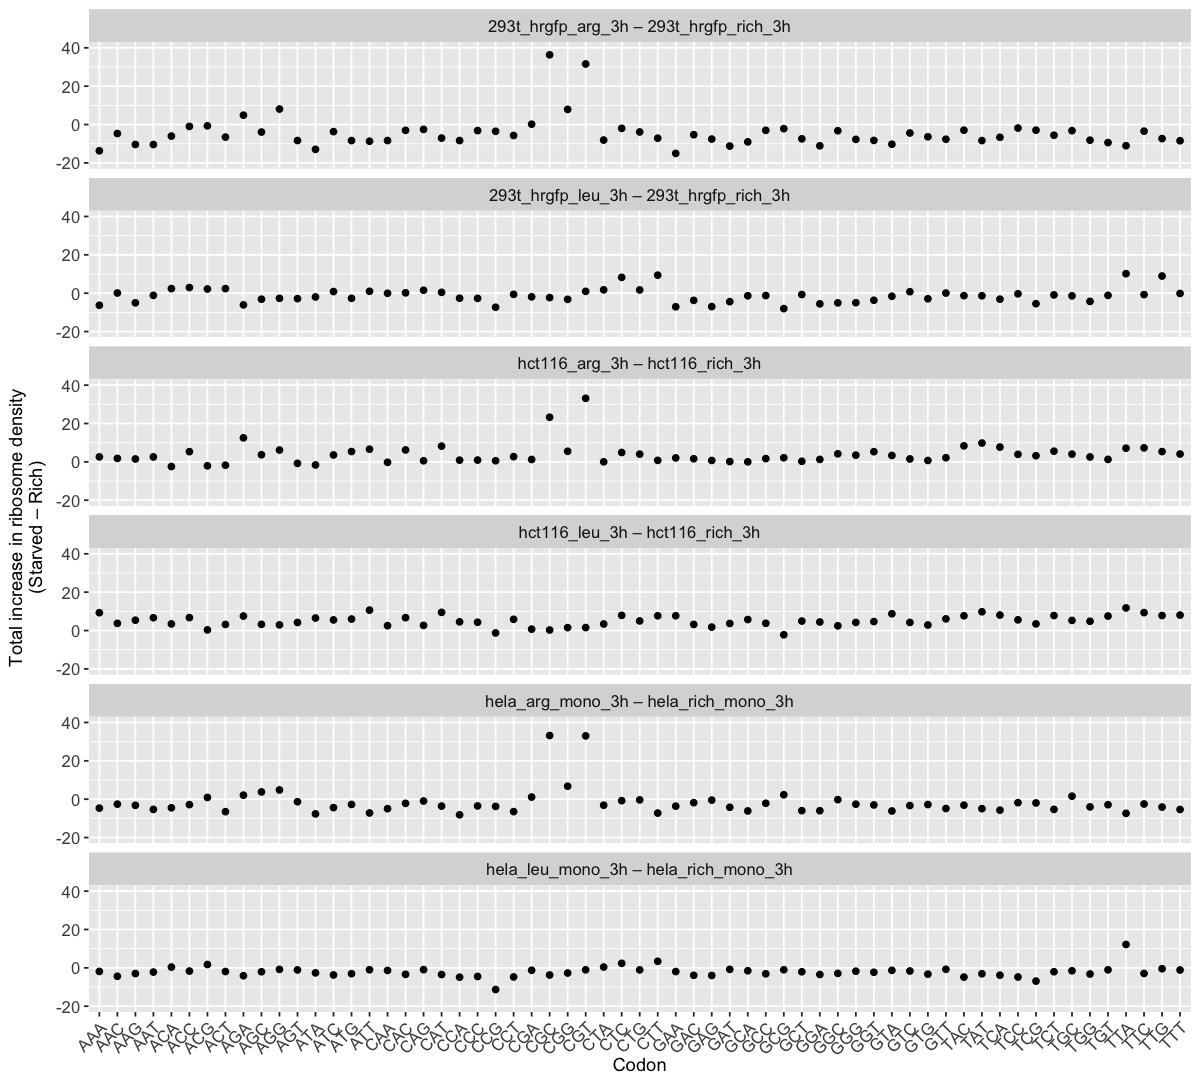

In [103]:
options(repr.plot.width = 10, repr.plot.height = 9)
p <- density.diff.sum %>%
  filter(plotnumber == 1) %>% 
  ggplot(aes(x = codon, y = density.sum))

p + geom_point() + facet_wrap(~samplepair, ncol = 1) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), axis.text=element_text(size=10, family='Arial'), strip.text=element_text(size=10, family='Arial')) + ylim(-20,40) +
  labs(x = 'Codon',
       y = 'Total increase in ribosome density\n(Starved \u2013 Rich)')

ggsave('../figures/20170912_summedcodondensitydifference_celltypes_fontadj.svg',
       width = 10.5, height = 9,units = 'in')

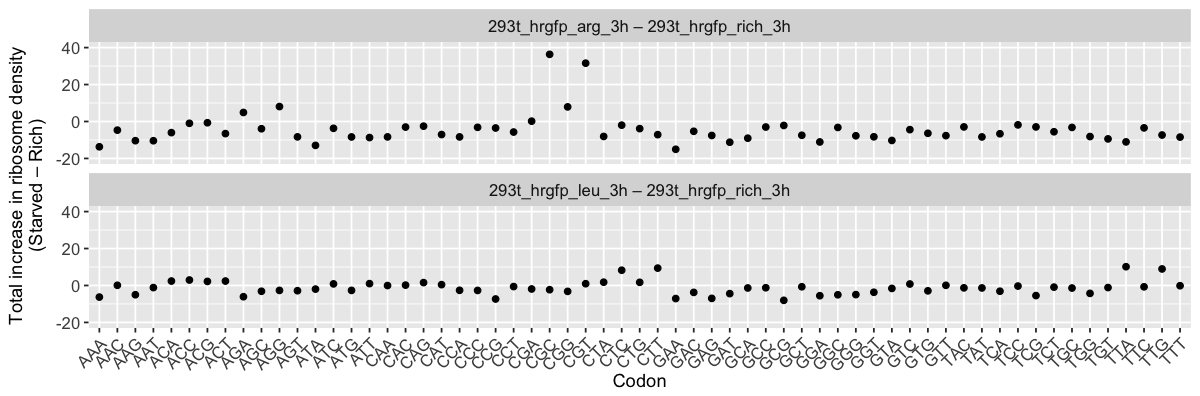

In [104]:
options(repr.plot.width = 10, repr.plot.height = 3.3)
p <- density.diff.sum %>%
  filter(plotnumber == 1 & cellline=='293t') %>% 
  ggplot(aes(x = codon, y = density.sum))

p + geom_point() + facet_wrap(~samplepair, ncol = 1) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), axis.text=element_text(size=10, family='Arial'), strip.text=element_text(size=10, family='Arial')) + ylim(-20,40) +
  labs(x = 'Codon',
       y = 'Total increase in ribosome density\n(Starved \u2013 Rich)')

ggsave('../figures/20170912_summedcodondensitydifference_293t_fontadj.svg',
       width = 10.5, height = 3.3,units = 'in')

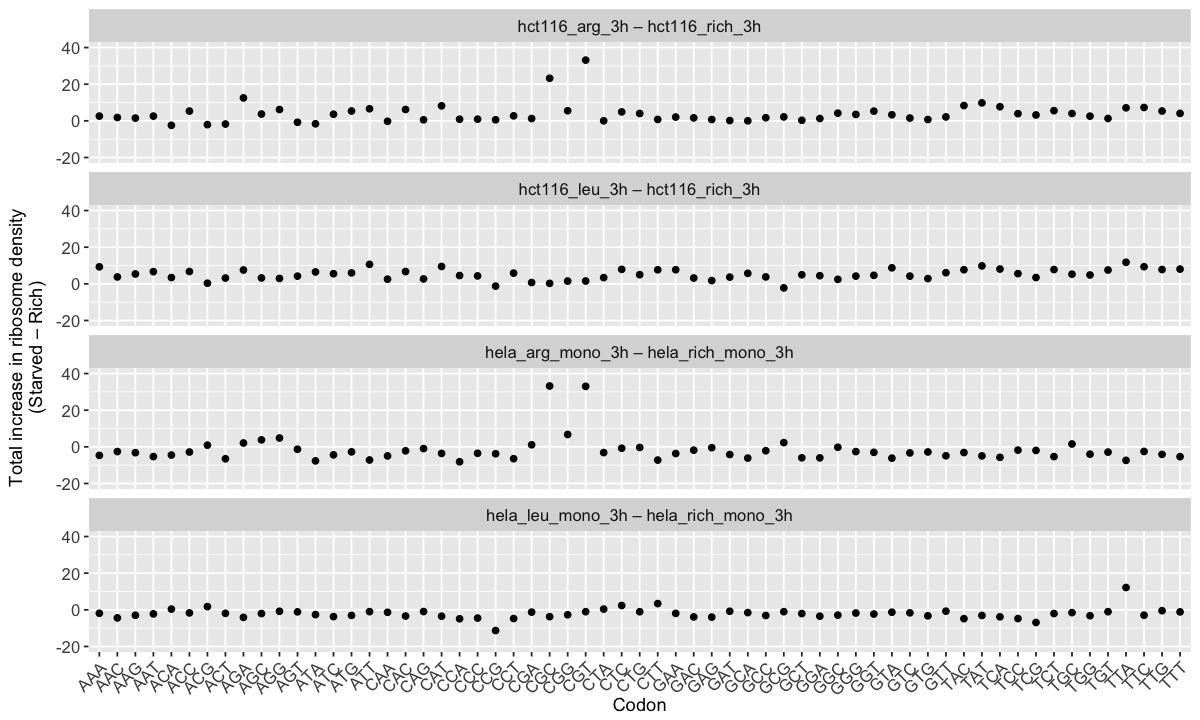

In [105]:
options(repr.plot.width = 10, repr.plot.height = 6)
p <- density.diff.sum %>%
  filter(plotnumber == 1 & cellline!='293t') %>% 
  ggplot(aes(x = codon, y = density.sum))

p + geom_point() + facet_wrap(~samplepair, ncol = 1) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), axis.text=element_text(size=10, family='Arial'), strip.text=element_text(size=10, family='Arial')) + ylim(-20,40) +
  labs(x = 'Codon',
       y = 'Total increase in ribosome density\n(Starved \u2013 Rich)')

ggsave('../figures/20170912_summedcodondensitydifference_hct116hela_fontadj.svg',
       width = 10.5, height = 6,units = 'in')

##### Figure 2

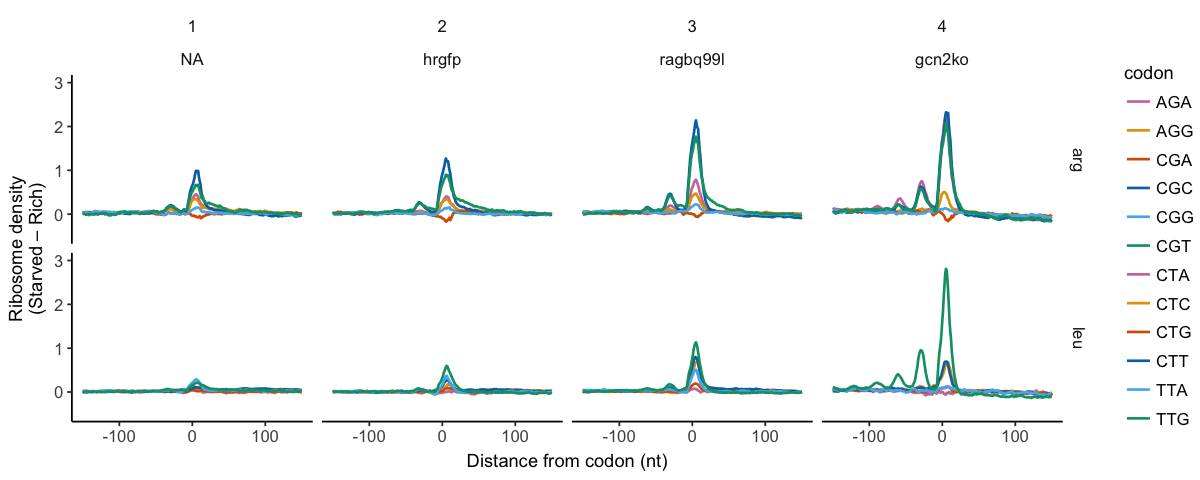

In [8]:
options(repr.plot.width = 10, repr.plot.height = 4)
p <- density.diff %>% 
  filter(plotnumber == 2 & plotaa == aa)  %>% 
  ggplot(aes(x = position, y = density.diff, color = codon))

p + 
  geom_line(size=0.75) +
  facet_grid(starv ~ perturblevel + modification) +
  # set colors manually
  scale_colour_manual(values=rep(cbPalette, 2)) +
  # set scales manually
  scale_x_continuous(limits=c(-150, 150)) +
  scale_y_continuous(limits=c(-0.5, 3)) +
  labs(x = 'Distance from codon (nt)',
       y = 'Ribosome density\n(Starved \u2013 Rich)') +
  theme_classic(base_family = 'Arial') + 
  theme(strip.background=element_blank(), axis.text=element_text(size=10), legend.text=element_text(size=10), strip.text=element_text(size=10))



ggsave('../figures/20170912_codondensitydifference_gcn2tor_fontlwadj.svg',
       width = 10, height = 4,units = 'in')

### plot codon density difference & summed density across perturbed mTOR/gcn2 lines

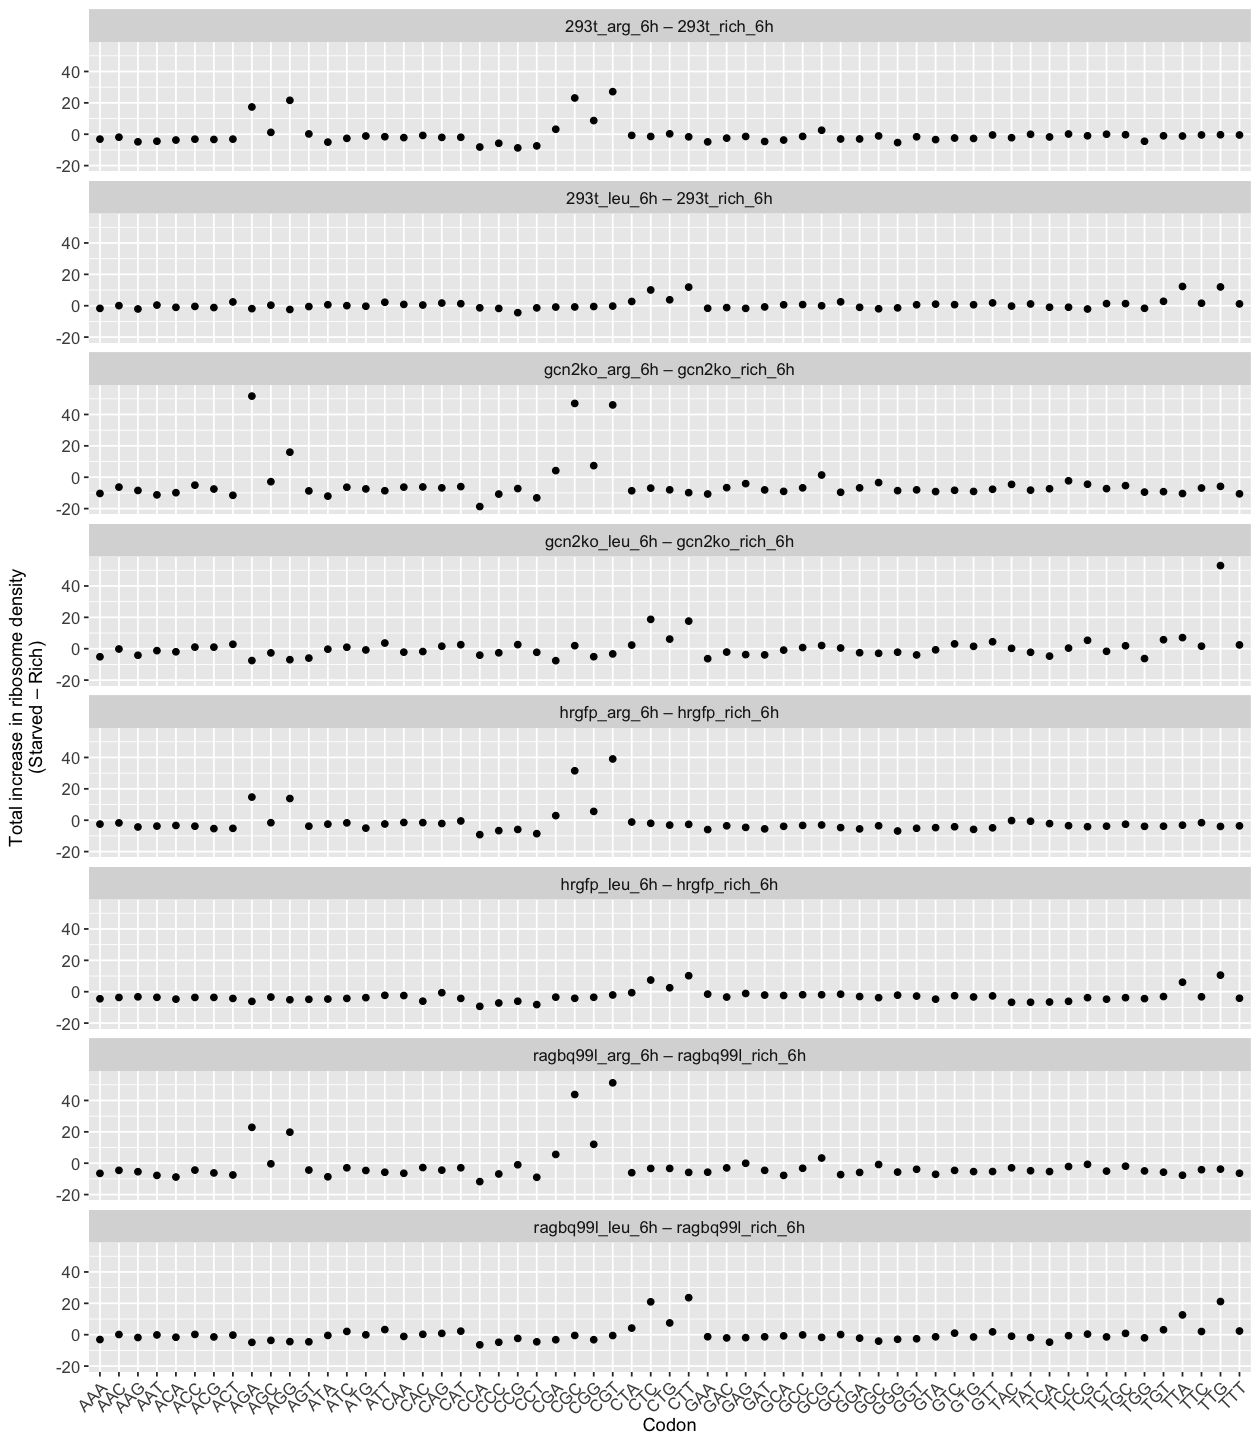

In [22]:
options(repr.plot.width = 10.5, repr.plot.height = 12)
p <- density.diff.sum %>%
  filter(plotnumber == 2) %>% 
  ggplot(aes(x = codon, y = density.sum))

p + geom_point() + facet_wrap(~samplepair, ncol = 1) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), axis.text=element_text(size=10, family='Arial'), strip.text=element_text(size=10, family='Arial')) + ylim(-20,55) +
  labs(x = 'Codon',
       y = 'Total increase in ribosome density\n(Starved \u2013 Rich)')

ggsave('../figures/20170913_summedcodondensitydifference_gcn2tor_fontadj.svg',
       width = 10.5, height = 12,units = 'in')

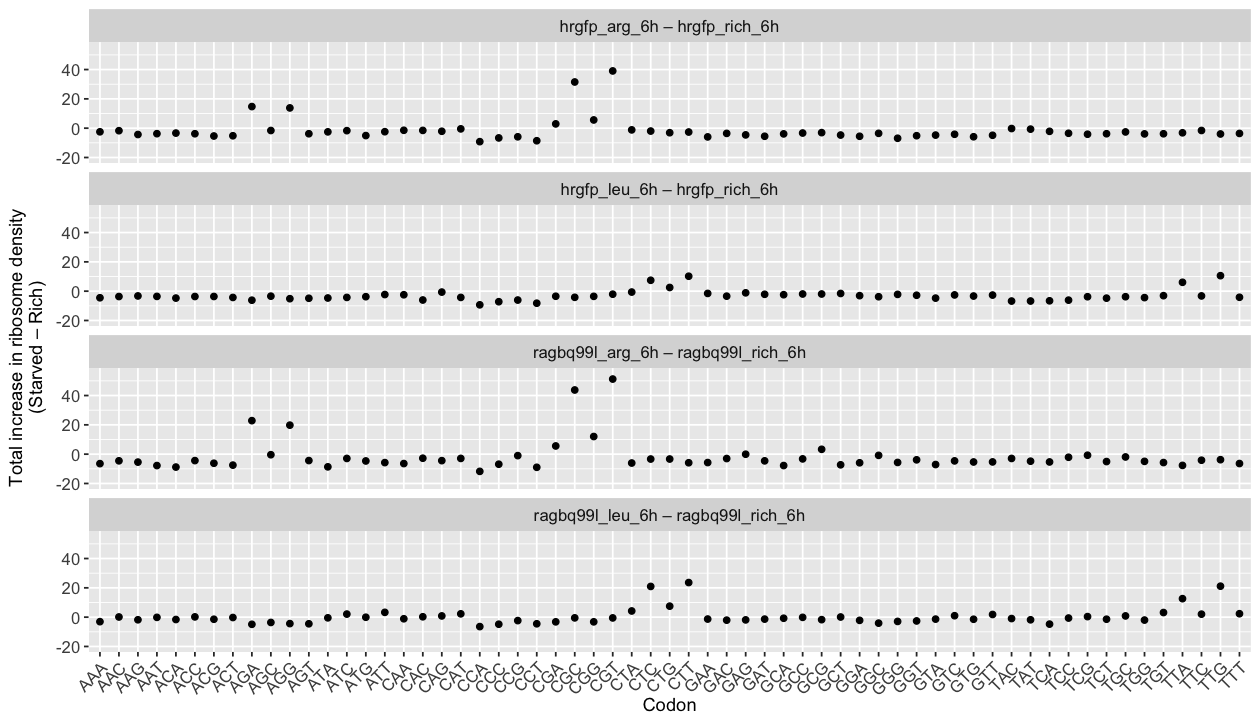

In [37]:
options(repr.plot.width = 10.5, repr.plot.height = 6)
p <- density.diff.sum %>%
  filter(plotnumber == 2 & modification == 'hrgfp' | modification == 'ragbq99l' | cellline=='293t' &drug!='torin') %>% 
  ggplot(aes(x = codon, y = density.sum))

p + geom_point() + facet_wrap(~samplepair, ncol = 1) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), axis.text=element_text(size=10, family='Arial'), strip.text=element_text(size=10, family='Arial')) + ylim(-20,55) +
  labs(x = 'Codon',
       y = 'Total increase in ribosome density\n(Starved \u2013 Rich)')

ggsave('../figures/20170913_summedcodondensitydifference_toronly_fontadj.svg',
       width = 10.5, height = 6,units = 'in')

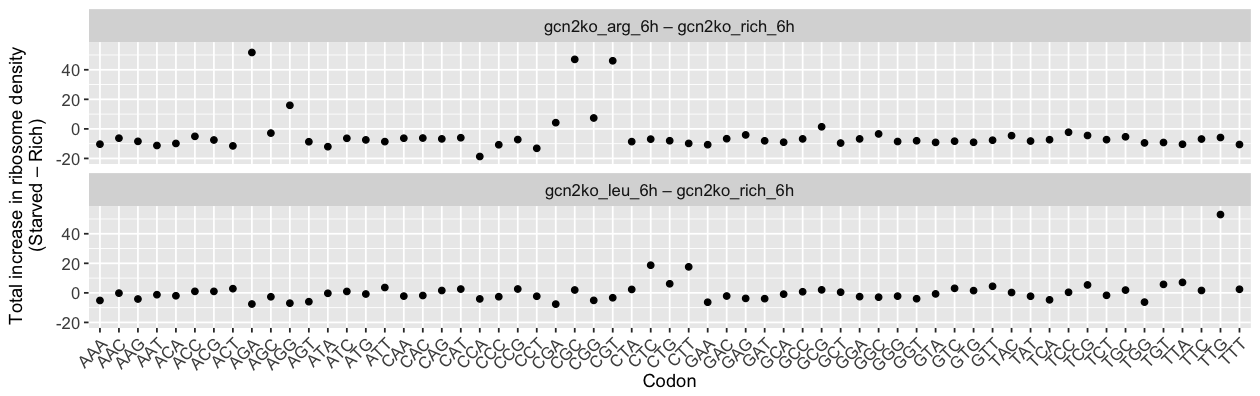

In [25]:
options(repr.plot.width = 10.5, repr.plot.height = 3.3)
p <- density.diff.sum %>%
  filter(plotnumber == 2 & modification == 'gcn2ko') %>% 
  ggplot(aes(x = codon, y = density.sum))

p + geom_point() + facet_wrap(~samplepair, ncol = 1) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), axis.text=element_text(size=10, family='Arial'), strip.text=element_text(size=10, family='Arial')) + ylim(-20,55) +
  labs(x = 'Codon',
       y = 'Total increase in ribosome density\n(Starved \u2013 Rich)')

ggsave('../figures/20170913_summedcodondensitydifference_gcn2koonly_fontadj.svg',
       width = 10.5, height = 3.3,units = 'in')

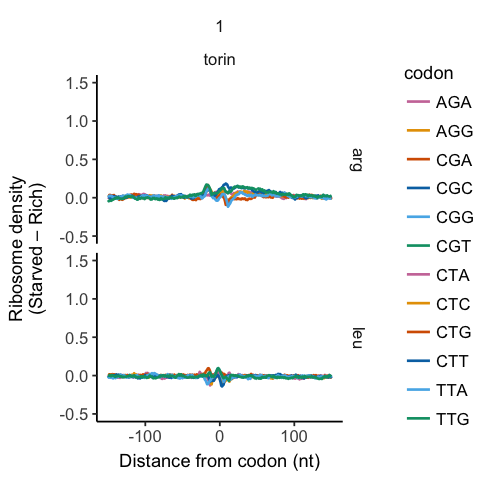

In [12]:
options(repr.plot.width = 4, repr.plot.height = 4)
p <- density.diff %>% 
  filter(plotnumber == 3 & plotaa == aa)  %>% 
  ggplot(aes(x = position, y = density.diff, color = codon))

p + 
  geom_line(size=0.75) +
  facet_grid(starv ~ perturblevel + drug) +
  # set colors manually
  scale_colour_manual(values=rep(cbPalette, 2)) +
  # set scales manually
  scale_x_continuous(limits=c(-150, 150)) +
  scale_y_continuous(limits=c(-0.5, 1.5)) +
  labs(x = 'Distance from codon (nt)',
       y = 'Ribosome density\n(Starved \u2013 Rich)') +
  theme_classic(base_family = 'Arial') +
  theme(strip.background=element_blank(), axis.text=element_text(size=10), legend.text=element_text(size=10), strip.text=element_text(size=10))


ggsave('../figures/20170912_codondensitydifference_torin_fontlwadj.svg',
       width = 4, height = 4,units = 'in')

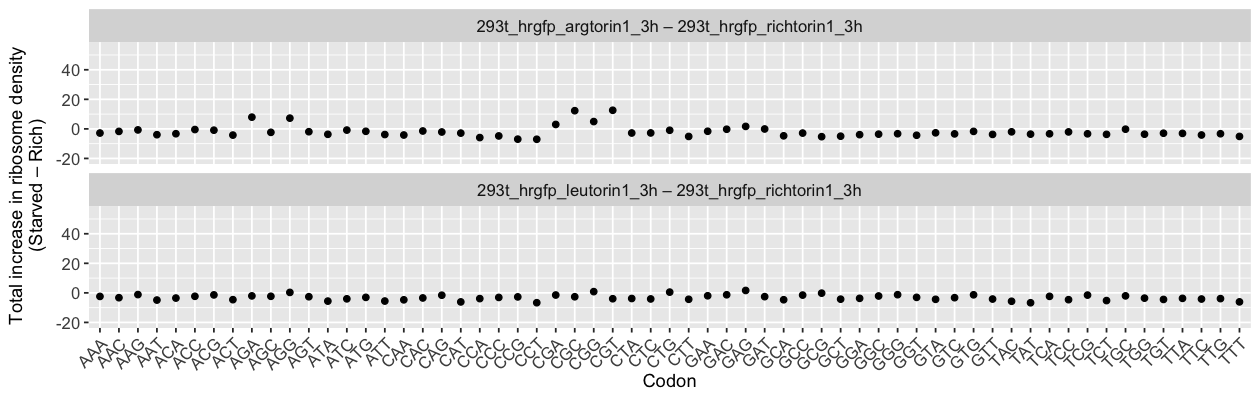

In [18]:
options(repr.plot.width = 10.5, repr.plot.height = 3.3)
p <- density.diff.sum %>%
  filter(plotnumber == 3) %>% 
  ggplot(aes(x = codon, y = density.sum))

p + geom_point() + facet_wrap(~samplepair, ncol = 1) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1), axis.text=element_text(size=10, family='Arial'), strip.text=element_text(size=10, family='Arial')) + ylim(-20,55) +
  labs(x = 'Codon',
       y = 'Total increase in ribosome density\n(Starved \u2013 Rich)')

ggsave('../figures/20170913_summedcodondensitydifference_torin_fontadj.svg',
       width = 10.5, height = 3.3, units = 'in')